# Dimensionality Reduction

In [1]:
from src.preprocessing import load_data, get_statistics, fill_empty_values
from src.outlier import interquartile_range
from src.visualize import get_histograms, get_boxplot, get_clients_map
from src.normalize import normalize, check_norm, centering
from pathlib import Path
from src.decomposition import svd, get_svd_info, get_errors, low_rank_approx, get_coefficient_matrix
import numpy as np
from src.distance_metric import pairwise_minkowski_distance
from src.decomposition import multidimensional_scaling

In [2]:
data_path = Path('data')
file_path = data_path / '23MAG_HW_1_v1.xls'

In [3]:
dataset = load_data(file_path)

In [4]:
get_statistics(dataset)

,Statistic,Age,Number of dependents,Salary,Years of stay in the region,Car price,Amount of credit
0,Mean,39.298507,2.086957,19861.764706,10.101449,20852.941176,198492.537313
1,Median,38.000000,2.000000,20250.000000,9.000000,20500.000000,200000.000000
2,Std,8.700427,0.996156,10169.342711,4.932321,10692.813469,99837.348500
3,Quantile (25%),34.000000,1.000000,11125.000000,7.000000,12000.000000,118000.000000
4,Quantile (50%),38.000000,2.000000,20250.000000,9.000000,20500.000000,200000.000000
5,Quantile (75%),46.000000,3.000000,27125.000000,14.000000,28000.000000,265500.000000


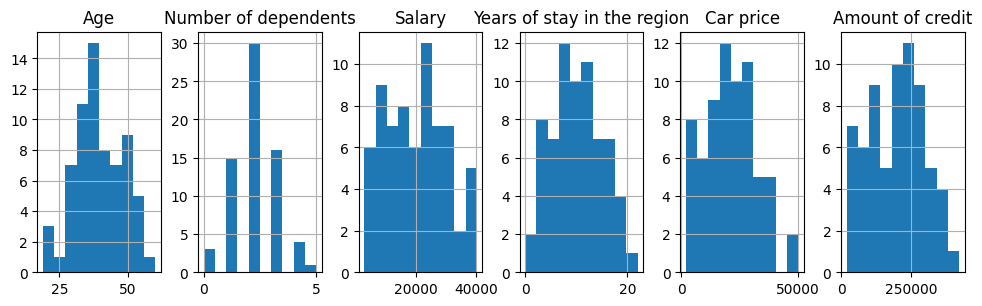

In [5]:
get_histograms(dataset)

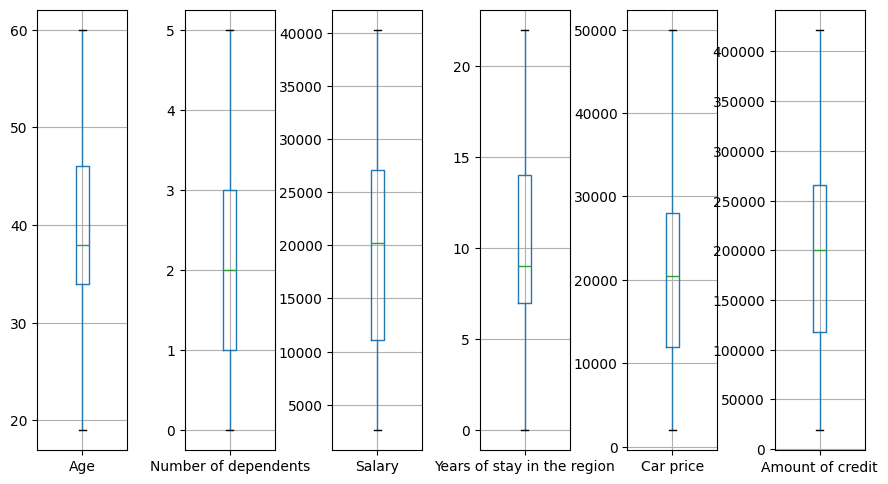

In [6]:
get_boxplot(dataset)

Fill empty values by `mean` value to prevent distribution changes

In [7]:
dataset = fill_empty_values(dataset)

To perform outlier removal `Interquartile Range` is offered

In [8]:
dataset = interquartile_range(dataset)

In [10]:
data_z = normalize(dataset)
matrix_z = data_z.to_numpy()
check_norm(data_z), data_z.describe()

(                   Column_name  Euclidean norm
 0                          Age             1.0
 1         Number of dependents             1.0
 2                       Salary             1.0
 3  Years of stay in the region             1.0
 4                    Car price             1.0
 5             Amount of credit             1.0,
              Age  Number of dependents     Salary  \
 count  70.000000             70.000000  70.000000   
 mean    0.117289              0.109073   0.107227   
 std     0.023165              0.049228   0.053183   
 min     0.059700              0.000000   0.013962   
 25%     0.102237              0.066619   0.060815   
 50%     0.116415              0.106590   0.106658   
 75%     0.133579              0.159886   0.144319   
 max     0.161191              0.213181   0.216412   
 
        Years of stay in the region  Car price  Amount of credit  
 count                    70.000000  70.000000         70.000000  
 mean                      0.108239   0.1

## Principal Component Analysis

In [11]:
matrix_u, singular_values, matrix_v = svd(matrix_z)
get_svd_info(singular_values)

,0
Singular values,"[2.33, 0.69, 0.23, 0.17, 0.11, 0.08]"
Total variance,6.0
Explained variances,"[0.9, 0.08, 0.01, 0.0, 0.0, 0.0]"
Explained variance (via 1 components),0.9
Explained variance (via 2 components),0.98
Explained variance (via 3 components),0.99
Explained variance (via 4 components),1.0
Explained variance (via 5 components),1.0


> Note our data could be explained via 2 components

In [12]:
decomposition_rank = 2 

In [21]:
approximated_matrix_z = low_rank_approx(matrix_u, singular_values, matrix_v, precision=decomposition_rank)
get_errors(matrix_z, approximated_matrix_z)

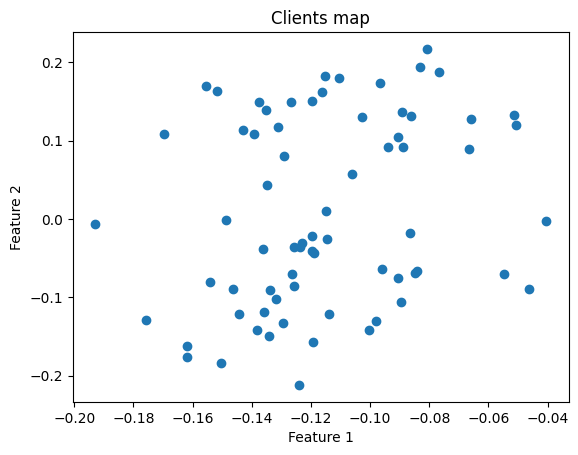

In [16]:
embeddings_pca = matrix_u[:,:decomposition_rank]
get_clients_map(embeddings_pca)

## Hidden Factors Interpretation

$Z_j = (S_1 * V_{j,1} * U_1) + (S_2 * V_{j,2} * U_2)$

In [22]:
coefficient_matrix = get_coefficient_matrix(matrix_z, singular_values, matrix_v, decomposition_rank)
approximated_matrix = matrix_u[:,:2] @ coefficient_matrix

coefficient_matrix

array([[-0.96569145,  0.68512228,  1.47517412, -0.88354544,  0.3416023 ,
        -0.97308397],
       [-0.28589612,  0.2330643 , -0.36059198,  0.28593158,  0.23559037,
        -0.27574837]])

Reflects the correlation between vectors $Z_j$ where $j=1, \dots, num\_features$ and $U_i, i=1,\dots, decomposition\_rank$

## Dimensionality reduction with MDS

In [19]:
pairwise_minkowski_distance(matrix_z, 2)

array([[0.        , 0.11592734, 0.0180853 , ..., 0.08001579, 0.02671458,
        0.13583065],
       [0.11592734, 0.        , 0.11514281, ..., 0.15182235, 0.12733107,
        0.08668374],
       [0.0180853 , 0.11514281, 0.        , ..., 0.08925094, 0.01429577,
        0.12804378],
       ...,
       [0.08001579, 0.15182235, 0.08925094, ..., 0.        , 0.09476974,
        0.2011015 ],
       [0.02671458, 0.12733107, 0.01429577, ..., 0.09476974, 0.        ,
        0.13400219],
       [0.13583065, 0.08668374, 0.12804378, ..., 0.2011015 , 0.13400219,
        0.        ]])

11 - 

Stress value: 0.25


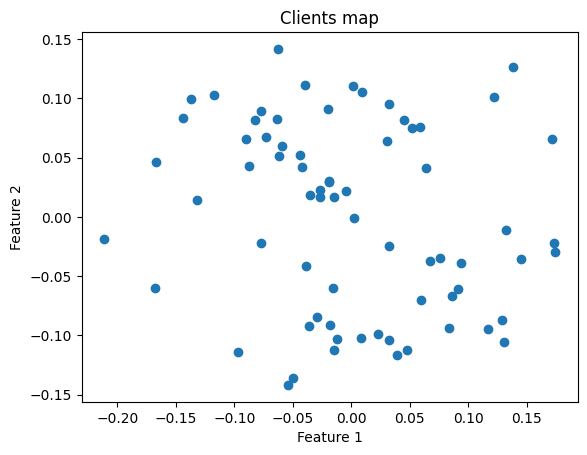

In [20]:
embeddings_mds = multidimensional_scaling(matrix_z, verbose=True)
get_clients_map(embeddings_mds)